In [2]:
library(cowplot)
library(magrittr)
suppressPackageStartupMessages(library(PFAM.db))
library(tidyverse)

results <- '../results/'
data <- '../data/'

tumors <- c('ALL', 'AML')

In [3]:
switches <- lapply(tumors, function(t) paste0(results, t, '/main_switches.tsv')) %>%
       lapply(read_tsv, col_types = 'ccccciiiiccillcd') %>%
       bind_rows %>%
       select(-Pfam_change, -Prosite_change)

In [4]:
only_switches <- select(switches, Experiment, Symbol, Control_transcript, Case_transcript)

pfam_ids <- as.data.frame(PFAMID) %>%
    set_colnames(c('Feature', 'Description')) %>%
    mutate(Description = gsub('_', ' ', Description))

pfam <- lapply(tumors, function(t) paste0(results, t, '/pfam_analysis.tsv')) %>%
    lapply(read_tsv, col_types = 'cccccccidddddddddd') %>%
    bind_rows %>%
    left_join(pfam_ids) %>%
    inner_join(only_switches)
               
prosite <- lapply(tumors, function(t) paste0(results, t, '/prosite_analysis.tsv')) %>%
    lapply(read_tsv, col_types = 'cccccccidddddddddd') %>%
    bind_rows %>%
    inner_join(only_switches)

# add functional information to switches
pfam_change <- group_by(pfam, Control_transcript, Case_transcript) %>%
    summarize(Pfam_change = any(What != 'Nothing'))

prosite_change <- group_by(prosite, Control_transcript, Case_transcript) %>%
    summarize(Prosite_change = any(What != 'Nothing'))

functional_changes <- full_join(pfam_change, prosite_change, by = c("Control_transcript", "Case_transcript"))

switches <- left_join(switches, functional_changes, by = c("Control_transcript", "Case_transcript")) %>%
    mutate(Pfam_change = ifelse(is.na(Pfam_change), FALSE, Pfam_change),
           Prosite_change = ifelse(is.na(Prosite_change), FALSE, Prosite_change),
           Functional = ifelse(Pfam_change | Prosite_change, 'Yes', 'No'))

rm(only_switches, functional_changes, pfam_change, prosite_change)
                  
# get signifficantly mutated features
mutated_features <- read_tsv('../data/supplementary_file_2.tsv',
         col_types = 'ccddddddii') %>%
    filter(adjp_mutation < 0.05) %>%
    left_join(pfam_ids, by = c("Pfam_id" = "Feature")) %>%
    .$Description

Joining, by = "Feature"
Joining, by = c("Experiment", "Control_transcript", "Case_transcript")
Joining, by = c("Experiment", "Control_transcript", "Case_transcript")


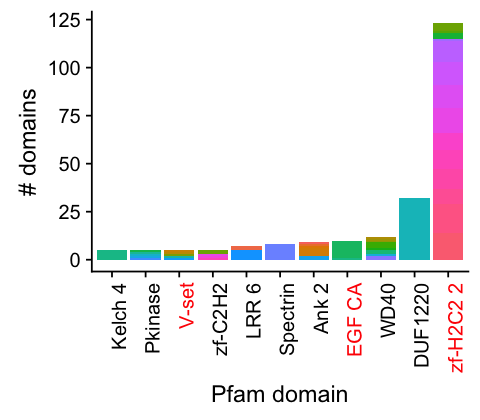

In [5]:
options(repr.plot.width=4, repr.plot.height=3.5)
top_domains <- pfam %>%
    filter(What != 'Nothing') %>%
    group_by(Symbol, Description) %>%
    summarize(n = n()) %>%
    ungroup %>%
    group_by(Description) %>%
    mutate(Total = sum(n)) %>%
    ungroup %>%
    filter(Total > 4 & !is.na(Description)) %>% 
    mutate(Description = fct_reorder(Description, Total))

colvec <- ifelse(levels(top_domains$Description) %in% mutated_features, "red", "black")

ggplot(top_domains, aes(Description, y = n, fill = Symbol)) +
    geom_bar(stat = 'identity') +
    labs(x = 'Pfam domain', y = '# domains') +
    theme(legend.position = 'none',
          axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1, colour = colvec))